In [1]:
#Simulation manual:
# Initalize the following objects:
    #CPG: Uses OR for EVT and EVT*core_vol to generate noEVT arm from EVT arm
    #M: Simulates mRS, age, and sex related mortality in the long run
    #RS: Simulates mRS, years since index stroke, and age related mRS decay due to recurrent stroke
    #C: Contains and computes costs per mRS per follow-up year, and costs of intial treatment/diagnostics
    #Q: Contains and computes QALYs per mRS per follow-up year
    #Sim: Combines the above objects in a simulator that runs simulations when called
    #df: Observed 90d mRS and baseline variables of all patients in EVT arm
#Baseline simulation:
    #Select IDs and pass df to run simulate_IDs -->
    #returns totals_res, extend_res
    #Running cohort_outcome_per_threshold will 
    #return:
        #out: NMB, d_costs, d_qalys per ID
        #aggr: average ICER, NMB, d_costs, d_qalys between strategies over the baseline cohort
#Probabilistic sensitivity:
    #Run probabilistic_simulation with predefined cohort size and number of resamples
    #also returns totals_res, extend_res but concatenated over all simulations (N_resamples)
    #Run probabilistic_cohort_outcomes_per_threshold
    #also returns per simulation average ICER, NMB, d_costs, d_qalys
 

In [4]:
import pandas as pd
import numpy as np
import os,sys
sys.path.append(r'C:\Users\hvanvoorst\PhD\git_repos\CLEOPATRA')
sys.path.append(r'C:\Users\henkvanvoorst\Documents\phd\git_repos\CLEOPATRA')
from Utils.utils import *
#from Utils.mRS_computation import *
from Model.Simulate import *
from Model.Mortality import Mortality
from Model.RecurrentStroke import RecurrentStroke
from Model.Utilities import Costs, QALYs
from Utils.Experiment import get_patient_dct, simulate_IDs
from Utils.Experiment import probabilistic_simulation, shift_tx_OR, shift_tx_core_volume_OR
from Utils.Outcomes import cohort_outcome
from Utils.Outcomes import probabilistic_cohort_outcomes
import warnings
warnings.filterwarnings('ignore')

p_inputs = r'C:\Users\henkvanvoorst\Documents\phd\CLEOPATRA\model_inputs'
#p_inputs = r'E:\CLEOPATRA\model_inputs'

root_sav = r'E:\CLEOPATRA\results'
root_fig = r'E:\CLEOPATRA\figures_june'
p_mort_file = os.path.join(p_inputs, 'Forecasted_mortality.xlsx')
p_HR_file = os.path.join(p_inputs, 'Stroke_recurrence.xlsx')
p_cost_file = os.path.join(p_inputs, 'Costs.xlsx')
p_qaly_file = os.path.join(p_inputs, 'QALYs.xlsx')
p_nums_mrs = os.path.join(p_inputs,'mRS_evt_noevt_core_vol.xlsx')
p_OR = os.path.join(p_inputs,'OR_mrcleantrial.xlsx')

CPG = ControlPatientGeneration(
                                p_OR,
                                p_nums_mrs,
                                verbal=False
                                )

M = Mortality(
              p_mort_file = p_mort_file, 
              HR_mrs = np.array([1.54,2.17,3.18,4.55,6.55]),
              years = np.arange(2021,2035)
                )

RS = RecurrentStroke(
                    file_p_HR = p_HR_file,
                    p_mrs_postrestroke = np.array([11/233, 21/233,18/233,22/233,6/233])
                    )

#inflation 2015-2022 to get costs for start reference year 2023
infl_py = [0.6,0.3,1.4,1.7,2.6,1.3,9]
start_infl = np.prod(np.array([1+i/100 for i in infl_py]))

C = Costs(
         file=p_cost_file,
         costs_IVT=950.82, costs_CTP=251.4, costs_EVT=9924.5,
         start_inflation=start_infl, # inflation factor before simulation (2015 -> 2022)
         discounting_rate=1.04,
         inflation_rate=1.017 #future inflation rate
            )

Q = QALYs(
        file = p_qaly_file,
        discounting_rate=1.015
        )

#PM:
# MR CLEAN trial: OR=1.86(CI:1.34-2.59) --> #OR: 1.67; 95% CI, 1.21 to 2.30
# n_evt=233: n_mrs<3 = 33% - 77, n_mrs>2=67% - 156
# n_noevt=267: n_mrs<3 = 19% - 52, n_mrs>2=80% - 214

# HERMES CTP: OR=2.520(CI:1.483-4.283)
# n_evt=289: n_mrs<3 = 136, n_mrs>2: 15


Sim = Simulate(CPG,M,RS,C,Q,5,2023,verbal=False)

In [ ]:
df = pd.read_excel(r'E:\CLEOPATRA\imputed_database.xlsx')
df.ivt_given = df.ivt_given-1
df.index = df.IDs
df['bl_occloc'] = df['bl_occloc'].replace(3,'M1').replace(2,'ICA-T').replace(4,'M2').replace(1,'ICA')
df['age_groups'] = pd.cut(df.r_age,bins=[0,50,60,70,80,1000])
df['otg_groups'] = pd.cut(df.t_otg,bins=[0,120,180,240,300,1000])
df.ivt_given = df.ivt_given-1
df.index = df.IDs
bl_cols = ['core_vol', 'penumbra_vol', 'mm_ratio', 
       'r_age', 'bl_nihss_sum', 't_otg','r_sex',
        'bl_collaterals','bl_hist_premrs','iat_post_etici',
        'age_groups','otg_groups']
BL = df[bl_cols]
bl_dct = BL.to_dict(orient='index')
print(df.shape)

In [2]:
#baseline simulations
#Sim.verbal = True
totals_res, extend_res = simulate_IDs(df.index,df,Sim)
#add clinical basline info for plots
totals_res = pd.concat([totals_res,BL],axis=1)
#aggr contains average results in NMB, ICER, d_costs,d_qalys
# of the cohort per different decision threshold
out,aggr = cohort_outcome(totals_res,
                        thresholds=np.arange(0,151,10), 
                        costs_per_ctp=0, #used for miss rate sim
                        multiply_ctp_costs = 0,#used for miss rate sim -->perform only on M2
                        miss_percentage = [0],#used for miss rate sim
                        WTP=80000)
#totals_res.to_excel(os.path.join(root_sav,'Baseline','results.xlsx'))
#extend_res.to_excel(os.path.join(root_sav,'Baseline','simulation_output.xlsx'))

100%|████████████████████████████████████████████████████████████████████████████████| 705/705 [00:07<00:00, 95.56it/s]


In [11]:
#probabilistic example
#extract per patient,strategy, and simulation the results
totals_res, extend_res = probabilistic_simulation(Sim,df,10,100)
#compute difference between arms (PSA computes cohort outcomes per simulation)
outs, aggrs = probabilistic_cohort_outcomes(totals_res,
                                            bl_dct,
                                            thresholds=np.arange(0,151,10),
                                            costs_per_ctp=0,
                                            multiply_ctp_costs = 0,
                                            miss_percentage = [0],
                                            WTP=80000)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  4.98it/s]


In [18]:
#probabilistic subgroup analyses
sgroup_res = subgroup_psa(df,
             col_subgroup,
             Sim,
             N_resamples,
             N_patients_per_cohort,
             thresholds=np.arange(0,151,10),
             costs_per_ctp=0,
             multiply_ctp_costs=0,
             miss_percentage=[0],
             seed=21)

'(70, 80]'

In [19]:
OR_evt_shifts = [-.3,-.2,-.1,0,.1]
OR_evt_corevol_shifts = [-.2,-.15,-.1,-.05,0]
OR_shift_psa(df,
             OR_evt_shifts,
             OR_evt_corevol_shifts,
             Sim,
             N_resamples, #10,000 in protocol --> use 1,000
             N_patients_per_cohort, #100 pt in protocol
             thresholds=np.arange(0,151,10),
             seed=21)

In [27]:
Sim.C.costs_CTP

296.3510013894528

In [ ]:
def probabilistic_cohort_outcomes(df_psa, 
                                bl_dct,
                               thresholds=np.arange(0,151,10),
                               costs_per_ctp=0,
                               multiply_ctp_costs = 0,
                               miss_percentage = [0],
                               WTP = 80000):
    
    #cohort_outcome_per_threshold for PSA simulations
    #df_res: per ID per simulation, 
    # costs and qalys (columns) for each strategy (in rows) 
    #bl-dct: should contain key=ID value=core_vol
    #WTP is used for NMB calculations
    #computes the outcomes per core_volume threshold per cohort average
    outs, aggrs = [],[]
    for simno in df_psa['simno'].unique():
        df_res = totals_res[df_psa['simno']==simno]
        df_res['core_vol'] = [bl_dct[ID]['core_vol'] for ID in df_res.index]
        df_res = df_res.reset_index(drop=True)
        #compute cohort results separately
        out,aggr = cohort_outcome(df_res,
                                thresholds=thresholds, 
                                costs_per_ctp=costs_per_ctp,
                                multiply_ctp_costs=multiply_ctp_costs,
                                miss_percentage=miss_percentage,
                                WTP=WTP)
        aggr['simno'] = simno
        outs.append(out)
        aggrs.append(aggr)
        
    outs = pd.concat(outs)
    aggrs = pd.concat(aggrs)
    aggrs = aggrs.reset_index(drop=True)
    return outs, aggrs

In [31]:
pd.DataFrame([1,2,3,4,5,6],columns=['HR_mort_mrs'])

,HR_mort_mrs
0,1
1,2
2,3
3,4
4,5
5,6


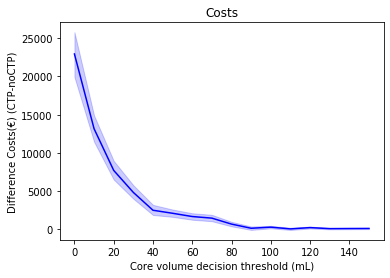

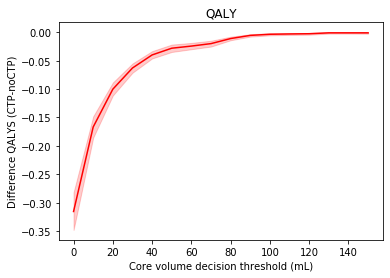

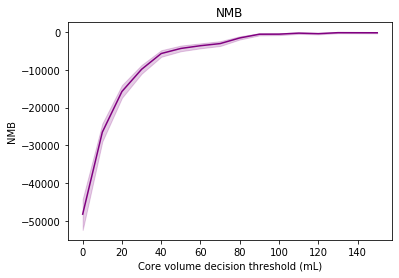

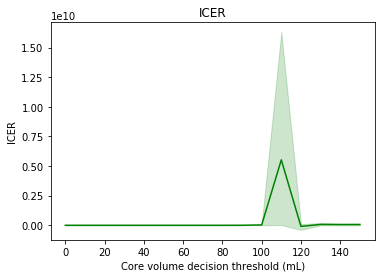

In [8]:

#write funciton for this
sns.lineplot(data=aggrs,x='threshold',y='d_costs',color='blue')
plt.ylabel('Difference Costs(€) (CTP-noCTP)')
plt.xlabel('Core volume decision threshold (mL)')
plt.title('Costs')
plt.gcf().subplots_adjust(left=0.15)
plt.savefig(os.path.join(root_fig,'Costs.png'))
plt.show()

sns.lineplot(data=aggrs,x='threshold',y='d_qalys',color='red')
plt.ylabel('Difference QALYS (CTP-noCTP)')
plt.xlabel('Core volume decision threshold (mL)')
plt.title('QALY')
plt.gcf().subplots_adjust(left=0.15)
plt.savefig(os.path.join(root_fig,'QALYs.png'))
plt.show()

sns.lineplot(data=aggrs,x='threshold',y='NMB', color='purple')
plt.xlabel('Core volume decision threshold (mL)')
plt.title('NMB')
plt.gcf().subplots_adjust(left=0.15)
plt.savefig(os.path.join(root_fig,'NMB.png'))
plt.show()

sns.lineplot(data=aggrs,x='threshold',y='ICER', color='green')
plt.xlabel('Core volume decision threshold (mL)')
plt.title('ICER')
plt.gcf().subplots_adjust(left=0.15)
plt.savefig(os.path.join(root_fig,'ICER_thr.png'))
plt.show()



N tot: 705
N and p corevol>50: 105 0.149
N and p corevol>70: 70 0.099
N and p corevol>100: 27 0.038


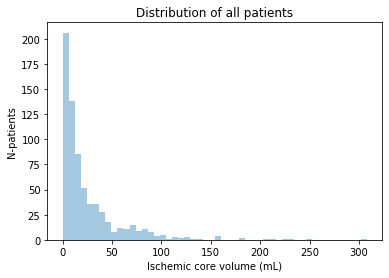

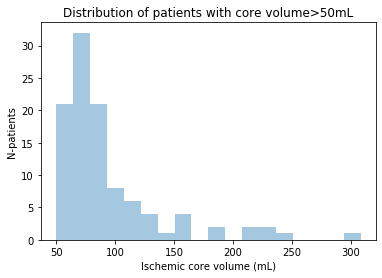

In [36]:
floc = r'E:\CLEOPATRA\figures_june'
n_tot = df.shape[0]
n50, n70, n100 = (df.core_vol>50).sum(), (df.core_vol>70).sum(),(df.core_vol>100).sum()
print('N tot:',df.shape[0])
print('N and p corevol>50:',n50, round(n50/n_tot,3))
print('N and p corevol>70:',n70, round(n70/n_tot,3))
print('N and p corevol>100:',n100, round(n100/n_tot,3))

#figures
sns.distplot(df.core_vol, kde=False)
plt.title('Distribution of all patients')
plt.ylabel('N-patients')
plt.xlabel('Ischemic core volume (mL)')
plt.savefig(os.path.join(floc,'dist_tot.png'))
plt.show()

sns.distplot(df.core_vol[df.core_vol>50], kde=False)
plt.title('Distribution of patients with core volume>50mL')
plt.ylabel('N-patients')
plt.xlabel('Ischemic core volume (mL)')
plt.savefig(os.path.join(floc,'dist50.png'))
plt.show()
